In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.stats import tukey_hsd
import starbars
import itertools

In [2]:
df_list = []
size_dict = {}
for filename in sorted(glob("*folds.csv")):
    y_col = filename.replace("_folds.csv","")
    df = pd.read_csv(filename)
    num_examples = len(df.UNIQUE_ID.unique())
    size_dict[y_col] = num_examples
    df_test = df.query("dset == 'test'")
    df_list.append([y_col,df_test, num_examples])

In [3]:
model_list = ["lgbm_morgan","lgbm_desc","chemprop","chemprop_rdkit"]
group_list = ["butina","random","scaffold"]
target_list = [x[0] for x in df_list]
stat_df_list = []
for idx, [y_col, tmp_df, num_examples] in enumerate(df_list):
    stat_list = []
    for k,v in tmp_df.groupby(["fold","group"]):
        fold, group = k
        for model in model_list:
            stat_list.append([fold,group,model,r2_score(v[y_col],v[model]),root_mean_squared_error(v[y_col],v[model])])
    stat_df = pd.DataFrame(stat_list,columns=["fold","group","model","r2","rmse"])
    stat_df['y_col'] = y_col
    stat_df_list.append(stat_df)
combo_df = pd.concat(stat_df_list)

In [4]:
def get_annotations(name_list, val_list):
    pv = tukey_hsd(*val_list).pvalue
    idx_dict = dict(zip(name_list,range(0,len(name_list))))
    annotations = []
    for i,j in itertools.combinations(model_list,2):
        p_value = pv[idx_dict[i],idx_dict[j]]
        if p_value < 0.05:
            annotations.append([i,j,pv[idx_dict[i],idx_dict[j]]])
    return annotations

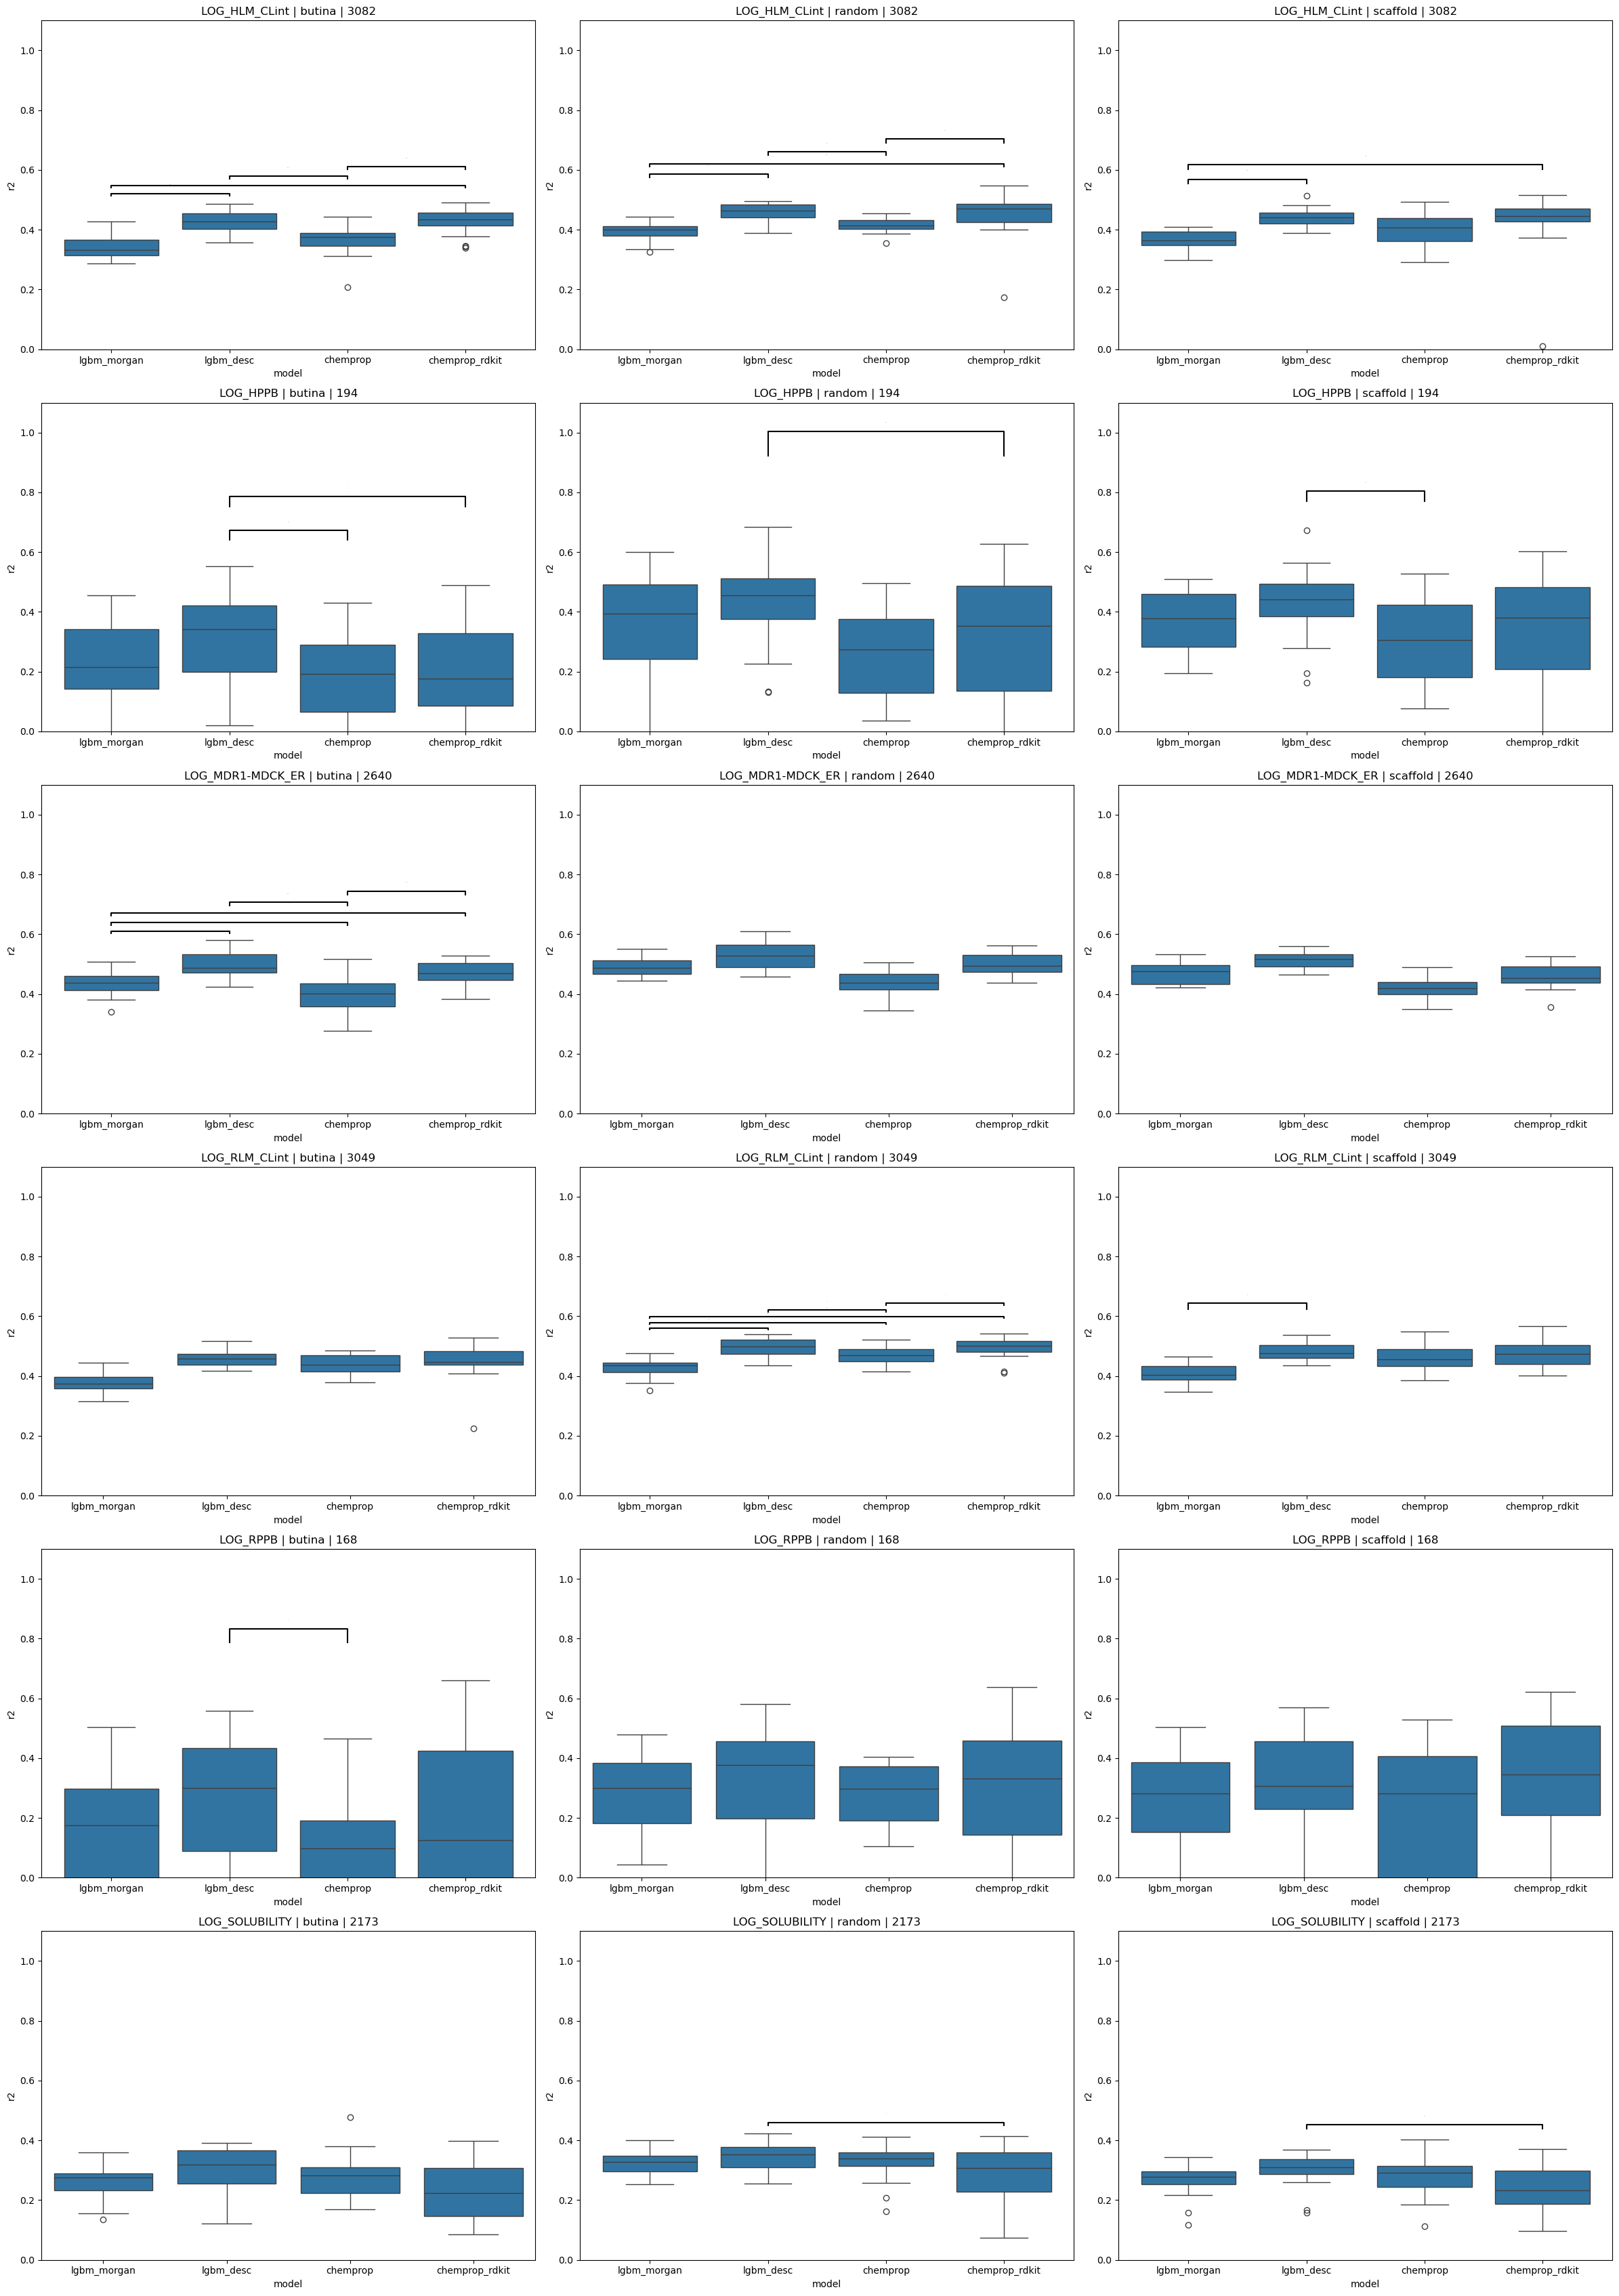

In [5]:
fig, axes = plt.subplots(6,3,figsize=(24,34))
for row,target in enumerate(target_list):
    for col,group in enumerate(group_list):
        tmp_df = combo_df.query("y_col == @target and group == @group")
        r2_list = []
        for model in model_list:
            r2_list.append(tmp_df.query("model == @model").r2.values)
        ann = get_annotations(model_list, r2_list)
        ax = sns.boxplot(x="model",y="r2",data=tmp_df,ax=axes[row][col])
        starbars.draw_annotation(ann,ax=ax,fontsize=0)  
        ax.set_ylim(0,1.1)
        ax.set_title(f"{target} | {group} | {size_dict[target]}")
plt.tight_layout()

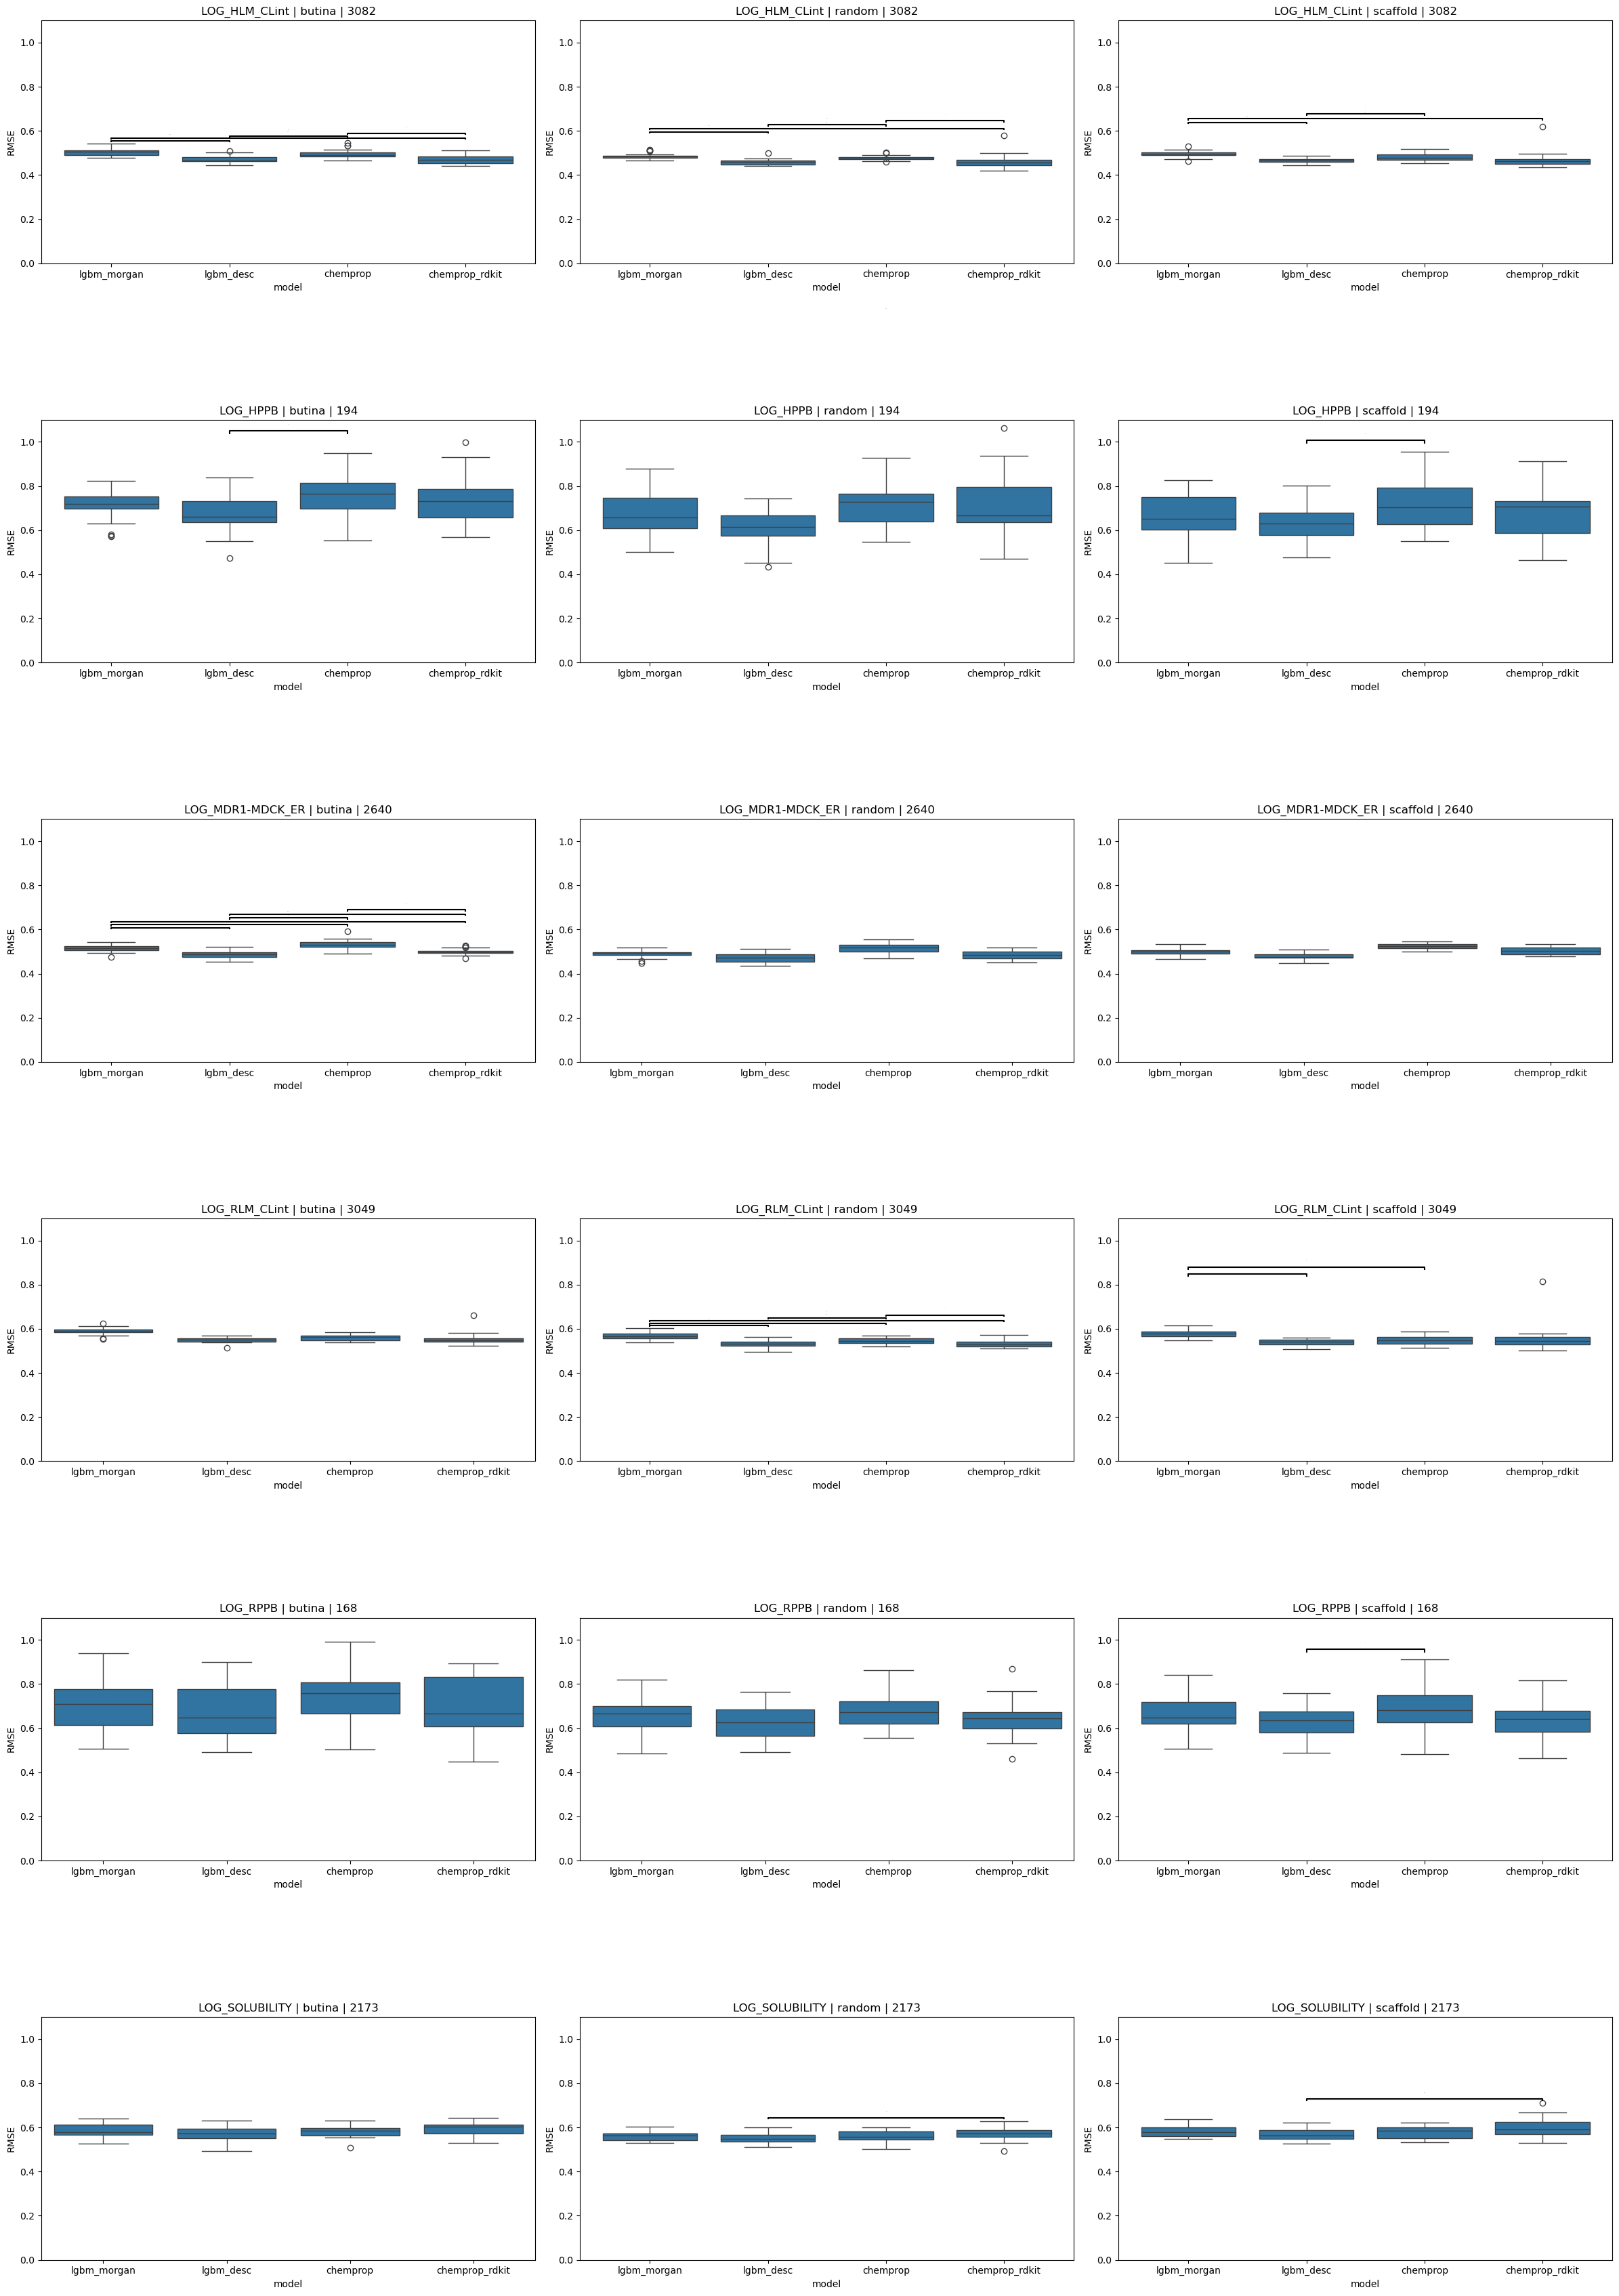

In [6]:
fig, axes = plt.subplots(6,3,figsize=(24,34))
for row,target in enumerate(target_list):
    for col,group in enumerate(group_list):
        tmp_df = combo_df.query("y_col == @target and group == @group")
        rmse_list = []
        for model in model_list:
            rmse_list.append(tmp_df.query("model == @model").rmse.values)
        ann = get_annotations(model_list, rmse_list)
        ax = sns.boxplot(x="model",y="rmse",data=tmp_df,ax=axes[row][col])
        ax.set_ylabel("RMSE")
        starbars.draw_annotation(ann,ax=ax,fontsize=0)  
        ax.set_ylim(0,1.1)
        ax.set_title(f"{target} | {group} | {size_dict[target]}")
plt.tight_layout()

In [7]:
def highlight_p(s):
    return ['background-color: lightgreen' if v < 0.05 else '' for v in s]

In [8]:
val_list = []
split = 'random'
y_col = 'LOG_HPPB'
for model in model_list:
    val_list.append(combo_df.query("y_col == @y_col and group == @split and model == @model").r2.values)
pd.DataFrame(tukey_hsd(*val_list).pvalue).round(3).style.apply(highlight_p).format("{:.2f}")

,0,1,2,3
0,1.00,0.82,0.87,0.08
1,0.82,1.00,0.37,0.01
2,0.87,0.37,1.00,0.35
3,0.08,0.01,0.35,1.00
